In [1]:
import matplotlib.pyplot
import matplotlib.gridspec
import pathlib
import pandas
import geopandas
import shapely
import mapclassify
import numpy


DATA_PATH = ((pathlib.Path().resolve()) / "data")

# load the polygon of the Jeseníky natural protected area provided by the Nature Conservation Agency of the Czech Republic
jeseniky = geopandas.read_file(DATA_PATH/"hruby_jesenik.gpkg")

# Load the contours that come from the DATA50 data provided by the State Administration of Land Surveying and Cadastre
contours = geopandas.read_file(DATA_PATH/"contours.gpkg")

In [2]:
#buffer the jeseniky area
jeseniky_buffer = geopandas.GeoDataFrame({"geometry":jeseniky.buffer(30000)}, crs=jeseniky.crs)

#clip the contours with the buffered area
contours_clip_buffered = contours.overlay(jeseniky_buffer, how="intersection")

In [3]:
#choose only the contours that are multiples of 100
contours_clip_buffered_reduced = contours_clip_buffered.loc[contours_clip_buffered["ELEVATION"]%100 == 0]
contours_clip_buffered_reduced.reset_index(inplace=True)

In [4]:
contours_merged = geopandas.GeoDataFrame(columns=["ELEVATION", "geometry"], crs="EPSG:5514")

# group the contour lines by elevation
contours_grouped = contours_clip_buffered_reduced.groupby("ELEVATION")

lines = []
multilines = []
elevations = []

# iterate through each group, flatten multilinestrings to linestrings and append all the strings from the group to "lines" list
# after retrieving all the lines from a group, merge them into a multiline and reset the "lines" list
for key, group in contours_grouped:
    for idx, row in group.iterrows():
        if type(row["geometry"]) == shapely.LineString:
            lines.append(row["geometry"])
        else:
            flattened_linestring = list(row["geometry"].geoms)
            for linestring in flattened_linestring:
                lines.append(linestring)
    multilines.append(shapely.MultiLineString(lines))
    elevations.append(row["ELEVATION"])
    lines = []
    
# populate the "contours_merged" GeoDF with multilines of contours and their respective altitudes
contours_merged = geopandas.GeoDataFrame({"ELEVATION": elevations, "geometry": multilines}, crs="EPSG:5514")

# because of a few discrepancies in topology, the contours had to be exported and repaired manualy
#contours_merged.to_file(DATA_PATH/"contours_to_repair.gpkg")

In [5]:
# load the repaired contours to a new GeoDF
contours_merged_repaired = geopandas.read_file(DATA_PATH/"contours_repaired.gpkg")

In [6]:
# split the jeseniky polygon to get the highest lying areas (>1400 m a.s.l.)
split = shapely.ops.split(jeseniky.at[0, "geometry"], contours_merged_repaired.iloc[-1]["geometry"])

# list the split parts
highest_zone_raw = []
for geom in split.geoms:
    highest_zone_raw.append(geom)

# create an outline of the jeseníky area
jeseniky_line = jeseniky.at[0, "geometry"].geoms[0].exterior

# if the split part doesn't touch the jeseníky area boundary, it corresponds to the highest zone and is added to a list
highest_zone = []
for part in highest_zone_raw:
    if not shapely.touches(part, jeseniky_line):
        highest_zone.append(part)

In [7]:
# multipolygon of the highest (>1400 m) zone
highest_zone_multipoly = shapely.MultiPolygon(highest_zone)

# create a list with the highest zone as the first entry
zones = [highest_zone_multipoly]


counter = 0

# iterate through the future altitude zone (based on 100m grouped contours) from the highest to the lowest (i.e. backwards)
for i in range(len(contours_merged_repaired)-1, -1, -1):
    # the lowest zone is a difference of the jeseniky area polygon and all the previously created polygons (i.e. what's left after creating all the zones before the last one)
    if i == 0:
        last_zone = jeseniky.at[0, "geometry"].buffer(0).difference(previous_zones_diss.at[0, "geometry"].buffer(0))
        zones.append(last_zone)

    # the highest zone is already present in the zones list, so we can skip it
    elif i == len(contours_merged_repaired)-1:
        continue

    # make all the zones except for the highest and lowest
    else:
        #split the jeseniky polygon by multiline representing a contour of certain value
        split = shapely.ops.split(jeseniky.at[0, "geometry"], contours_merged_repaired.at[i, "geometry"])
    
        
        # iterrate through split (GeometryCollection) to list the split polygons
        split_parts = []
        for geom in split.geoms:
            split_parts.append(geom)
    
        #create a multipolygon from split polygons
        split_multipolygon = shapely.MultiPolygon(split_parts)
    
        
        #dissolve all the polygons already present in the list that contains the elevation zones created so far into a geodataframe
        previous_zones_diss = geopandas.GeoDataFrame({"geometry": zones}, crs="EPSG:5514").dissolve()
        #expload the multipolygon to polygons (all the polygons that make up the elevation zones created so far)
        previous_geom_polys = previous_zones_diss.explode()
    
        #find split polygons of the zone currently being constructed that contain any polygon from previously created altitude zones and list them
        # NOTE: VERY INEFFECTIVE i guess, FIX IT
        touching_parts = []
        for part in split_parts:
            for idx, row in previous_geom_polys.iterrows():
                if row["geometry"].buffer(1e-6).within(part):
                    touching_parts.append(part)
    
        #find split polygons of the zone currently being constructed that do not contain any holes (i.e. they are the highest parts in their immediate surroundings)
        # in order to not consider the lower-lying vaster areas with no "holes" in them as peaks, the area of the split part must be < 2 km2
        peaks = []
        for part in split_parts:
            if len(part.interiors) == 0 and part.area < 2000000 and not part.intersects(jeseniky_line):
                peaks.append(part)
    
        #connect polygons containing higher zones and polygons of the according altitude zone that act as the local max altitudes
        touching_parts_and_peaks = touching_parts + peaks
    
        #transform the combined polygons into a multipolygon
        touching_parts_multipoly = shapely.MultiPolygon(touching_parts_and_peaks)
        
        #subtract all the previously created zones from the zone being created
        #buffer(0) fixes all the tiny lil topological errors and inconsistencies - this is the newly created altitude zone
        zone_multipoly_cut = touching_parts_multipoly.buffer(0).difference(previous_zones_diss.at[0, "geometry"].buffer(0))
    
        #append the newly-created zone to a list of all the zones created so far
        zones.append(zone_multipoly_cut)
    
    counter += 1
    #if counter >5:
     #   break


In [8]:
# reverse the list of altitudes to make its order descending
elevations_desc = elevations[::-1]

In [9]:
#create a GeoDF containing the altitude zones and their lower-boundary altitude
zones_gdf = geopandas.GeoDataFrame({"geometry":zones, "elevation": elevations_desc}, crs="EPSG:5514")
zones_gdf["id"] = [i for i in range(len(zones_gdf))]

In [10]:
#clip the contours only to Jeseníky area for visualization purposes
contours_clip = contours_merged_repaired.overlay(jeseniky, how="intersection")

In [11]:
# read csv of selected bird species observations to dataframes
# data come from an birds observation database avif.cz ran by Czech Orinthological Society

anthus_spinoletta = pandas.read_csv(DATA_PATH/"anthus_spinoletta.csv", sep=";")
crex_crex = pandas.read_csv(DATA_PATH/"crex_crex.csv", sep=";")
picoides_tridactylus = pandas.read_csv(DATA_PATH/"picoides_tridactylus.csv", sep=";")
glaucidium_passerinum = pandas.read_csv(DATA_PATH/"glaucidium_passerinum.csv", sep=";")

In [12]:
anthus_spinoletta.columns

Index(['ListID', 'Created', 'Date', 'TimeStart', 'TimeEnd', 'NameCS', 'Note',
       'Observers', 'SiteName', 'SiteNote', 'Latitude', 'Longitude',
       'CoordinatesSetByUser', 'DistanceCovered', 'MunicipalityPart',
       'Municipality', 'District', 'Region', 'ListProjects', 'ItemID',
       'Rarity', 'SpeciesID', 'SpeciesNameLA', 'SpeciesName', 'ItemTime',
       'ItemLatitude', 'ItemLongitude', 'Count', 'CountMin', 'CountMax',
       'CountExact', 'Age', 'Sex', 'Activity', 'Group', 'RingMark', 'ItemNote',
       'TagUncertain', 'TagFirstArrivals', 'PhotosCount', 'CommentsCount',
       'ItemProjects', 'ListLink', 'ItemLink'],
      dtype='object')

In [13]:
# put the DFs into a dictionary

species = {
    "anthus_spinoletta" : anthus_spinoletta, 
    "crex_crex" : crex_crex, 
    "picoides_tridactylus" : picoides_tridactylus,
    "glaucidium_passerinum" : glaucidium_passerinum

    }

# define the columns that will be kept
columns_to_keep = ["Date", "Latitude", "Longitude", "CoordinatesSetByUser", "Municipality", "SpeciesNameLA", "SpeciesName", "Count", "Sex", "Activity"]

In [14]:
# reduce the columns in each species' DF
for name, bird_species in species.items():
    species[name] = bird_species[columns_to_keep]

In [15]:
# transform DFs into GeoDFs, reproject to EPSG: 5514
for name, bird_species in species.items():
    species[name] = geopandas.GeoDataFrame(bird_species, geometry=geopandas.points_from_xy(bird_species.Longitude, bird_species.Latitude), crs = "EPSG:4326")
    species[name] = species[name].to_crs("EPSG:5514")
    species[name] = geopandas.clip(species[name], jeseniky)

In [16]:
# take dataframe with altitude zones polygons and sort it in ascending order, calculate area of each zone in km2
zones_joined_count = zones_gdf.copy()
zones_joined_count = zones_joined_count.sort_values(by="elevation", ascending=True)
zones_joined_count["area_km2"] = zones_joined_count.area/1000000

#for each species, join spatial corresponding altitude zone to each observation and group by elevation zones
for name, bird_species in species.items():
    joined = zones_joined_count.sjoin(species[name], how="right", predicate="contains")
    grouped_by = joined.groupby("elevation")

    #create two list that will contain altitude zones and respective number of observation of a given species within that zone
    alt_zones = []
    counts = []

    #populate the lists
    for idx, group in grouped_by:
        alt_zones.append(float(idx))
        counts.append(len(group))

    #create a DF with elevations and counts of observations within them
    counts_in_zones = pandas.DataFrame(data={"elevation":alt_zones, "counts":counts})

    #join count of observations of a given species to corresponding zone in a GeoDF containing the altitude zones as multipolygons
    zones_joined_count = zones_joined_count.merge(counts_in_zones, left_on="elevation", right_on="elevation", how="left")
    #assign 0 observations to the zones where no observations were made
    zones_joined_count["counts"] = zones_joined_count["counts"].fillna(0)

    #change the datatype of n of observations and elevation from float to int
    zones_joined_count[["elevation", "counts"]] = zones_joined_count[["elevation", "counts"]].astype(int)
    #rename the column with the number of observations to the name of a given species, so it lasts in the DF and is not overwritten in the next iterration
    zones_joined_count = zones_joined_count.rename(columns={"counts":name})

    #make the number of observations relative to area so it can be safely 1visualized in a choropleth map later on
    zones_joined_count[name+"_rel_km2"] = zones_joined_count[name] / zones_joined_count["area_km2"]


zones_joined_count

,geometry,elevation,id,area_km2,anthus_spinoletta,anthus_spinoletta_rel_km2,crex_crex,crex_crex_rel_km2,picoides_tridactylus,picoides_tridactylus_rel_km2,glaucidium_passerinum,glaucidium_passerinum_rel_km2
0,"MULTIPOLYGON (((-533650.12 -1044268.94, -53364...",300,11,44.913288,1,0.022265,30,0.667954,1,0.022265,0,0.000000
1,"MULTIPOLYGON (((-548448.87 -1050654.25, -54842...",400,10,34.616170,1,0.028888,27,0.779982,1,0.028888,0,0.000000
2,"MULTIPOLYGON (((-558820.19 -1062014.87, -55881...",500,9,71.350679,4,0.056061,70,0.981070,3,0.042046,1,0.014015
3,"MULTIPOLYGON (((-558331.19 -1061248.912, -5583...",600,8,126.101926,7,0.055511,85,0.674058,1,0.007930,2,0.015860
4,"MULTIPOLYGON (((-530134.54 -1066469.759, -5301...",700,7,156.987580,10,0.063699,114,0.726172,4,0.025480,6,0.038220
5,"MULTIPOLYGON (((-557157.182 -1058810.837, -557...",800,6,118.189325,2,0.016922,0,0.000000,0,0.000000,5,0.042305
6,"MULTIPOLYGON (((-534817.962 -1066834.428, -534...",900,5,80.144292,0,0.000000,0,0.000000,1,0.012477,1,0.012477
7,"MULTIPOLYGON (((-534275.5 -1066446.751, -53427...",1000,4,64.141908,3,0.046771,1,0.015590,9,0.140314,4,0.062362
8,"MULTIPOLYGON (((-537925.482 -1057307.03, -5379...",1100,3,39.393791,4,0.101539,0,0.000000,15,0.380771,2,0.050769
9,"MULTIPOLYGON (((-536594.383 -1059336.506, -536...",1200,2,25.136295,23,0.915012,0,0.000000,12,0.477397,1,0.039783


In [17]:
anthus = zones_joined_count[["elevation", "anthus_spinoletta"]].copy().set_index("elevation")
crex = zones_joined_count[["elevation", "crex_crex"]].copy().set_index("elevation")
picoides = zones_joined_count[["elevation", "picoides_tridactylus"]].copy().set_index("elevation")
glaucidium = zones_joined_count[["elevation", "glaucidium_passerinum"]].copy().set_index("elevation")

C:\Users\kirner\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\kirner\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\kirner\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\kirner\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\kirner\AppData\Local\Temp\ipykernel_15604\615781366.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  matplotlib.pyplot.tight_layout()


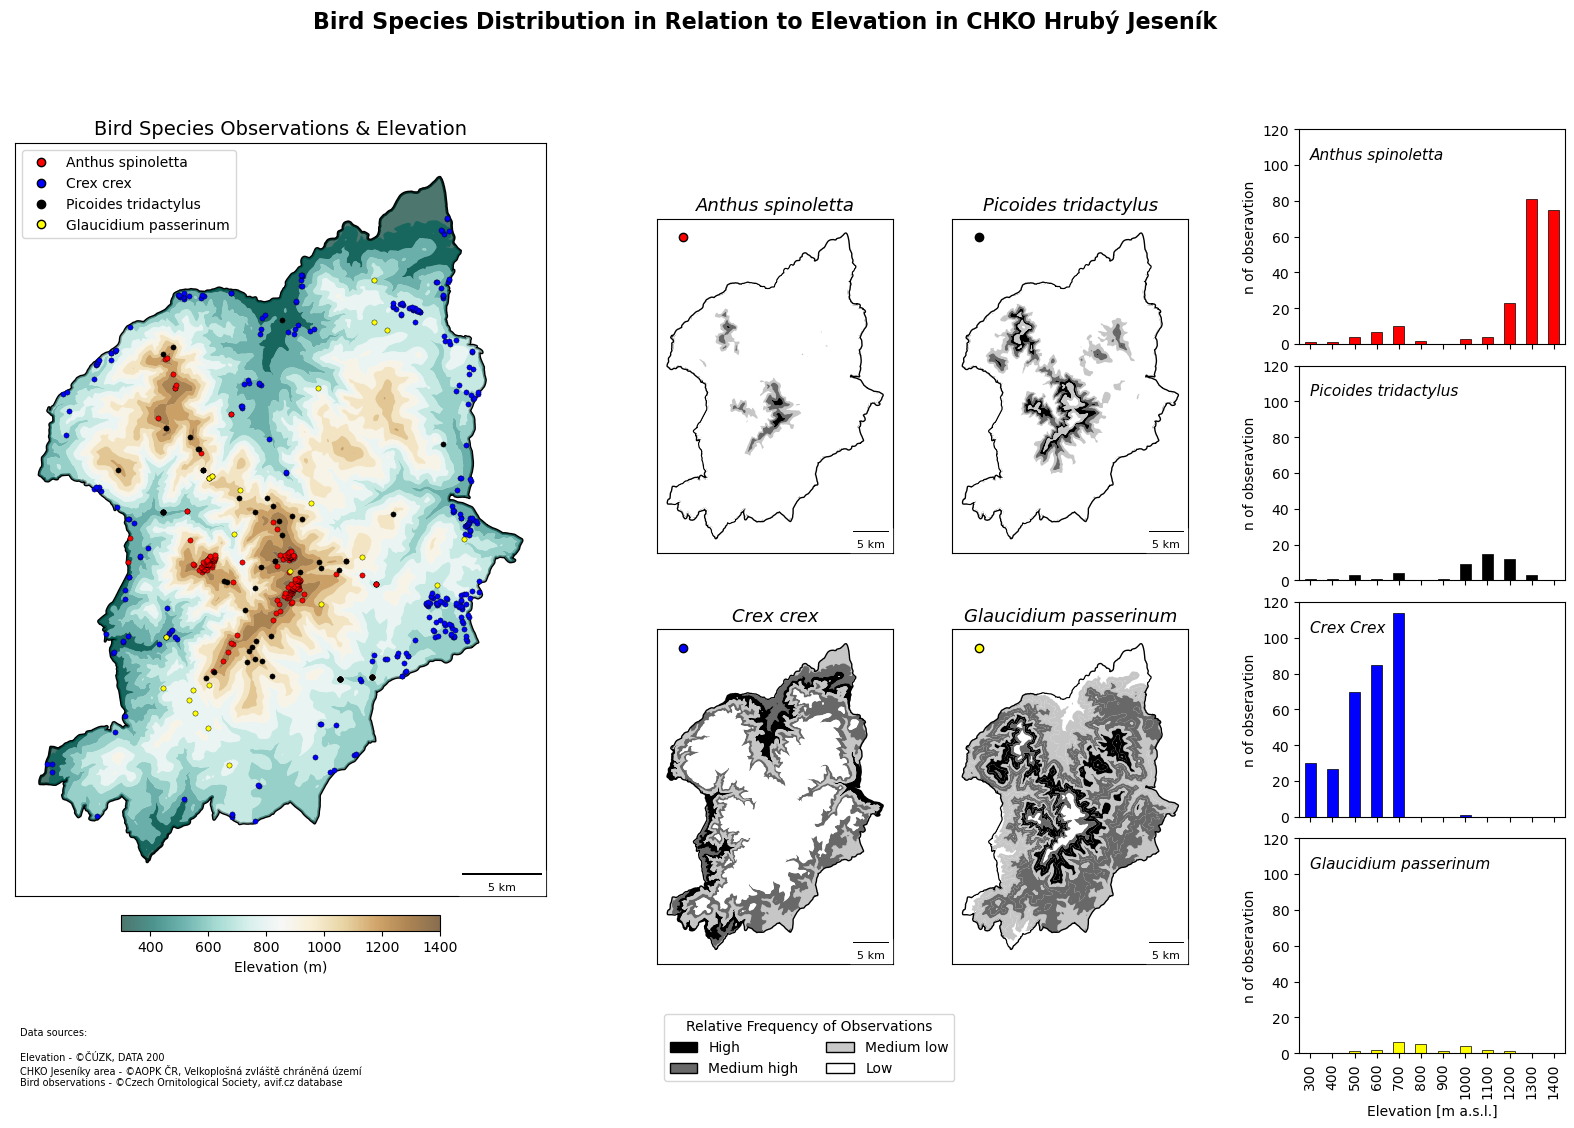

In [18]:
fig = matplotlib.pyplot.figure(figsize=(20, 12))
gs = matplotlib.gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 2, 1], wspace=0.25)

ax1 = fig.add_subplot(gs[0,0])

# Middle block: 2×2
gs_middle = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], hspace=-0.2, wspace=0.25)

ax2 = fig.add_subplot(gs_middle[0, 0])
ax3 = fig.add_subplot(gs_middle[1, 0])
ax4 = fig.add_subplot(gs_middle[0, 1])
ax5 = fig.add_subplot(gs_middle[1, 1])


# Right block: 4 stacked (1 column × 4 rows)
gs_right = matplotlib.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[0, 2], hspace=0.1)
ax6 = fig.add_subplot(gs_right[0, 0])
ax7 = fig.add_subplot(gs_right[1, 0])
ax8 = fig.add_subplot(gs_right[2, 0])
ax9 = fig.add_subplot(gs_right[3, 0])


for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")


jeseniky.plot(ax=ax1, facecolor="None", edgecolor="black", lw=2)
zones_joined_count.plot(ax=ax1, column="elevation", cmap="BrBG_r", alpha=0.7, legend=True, legend_kwds={"orientation": "horizontal", "label": "Elevation (m)", "shrink": 0.6, "pad": 0.02, "alpha":0.7})
species["crex_crex"].plot(ax=ax1, color="#0000ff", markersize=14, edgecolor="black", lw=0.3, legend=True)
species["anthus_spinoletta"].plot(ax=ax1, color="red", markersize=14, edgecolor="black", lw=0.3, legend=True)
species["picoides_tridactylus"].plot(ax=ax1, color="black", markersize=14, edgecolor="black", lw=0.3, legend=True)
species["glaucidium_passerinum"].plot(ax=ax1, color="yellow", markersize=14, edgecolor="black", lw=0.3, legend=True)

jeseniky.plot(ax=ax2, facecolor="None", edgecolor="black", lw=2)
#use the jenks classification so that the variance is as low as possible within the bins and as high as possible between the bins
zones_joined_count.plot(ax=ax2, column="anthus_spinoletta_rel_km2", cmap="Greys", scheme="fisherjenks", classification_kwds={'k': 4})    

jeseniky.plot(ax=ax3, facecolor="None", edgecolor="black", lw=2)
zones_joined_count.plot(ax=ax3, column="crex_crex_rel_km2", cmap="Greys", scheme="fisherjenks", legend=True, classification_kwds={'k': 4})

jeseniky.plot(ax=ax4, facecolor="None", edgecolor="black", lw=2)
zones_joined_count.plot(ax=ax4, column="picoides_tridactylus_rel_km2", cmap="Greys", scheme="fisherjenks", classification_kwds={'k': 4})

jeseniky.plot(ax=ax5, facecolor="None", edgecolor="black", lw=2)
zones_joined_count.plot(ax=ax5, column="glaucidium_passerinum_rel_km2", cmap="Greys", scheme="fisherjenks", classification_kwds={'k': 4})



anthus.plot(ax=ax6, kind="bar", ylim=[0, 120], legend=False, color="red", edgecolor="black", linewidth=0.5, xlabel="", ylabel="n of obseravtion").set_xticklabels([])
ax6.text(0, 110, "Anthus spinoletta", ha='left', va='top', fontsize=11, fontstyle="italic") 

picoides.plot(ax=ax7, kind="bar", ylim=[0, 120], legend=False, color="black", edgecolor="black", linewidth=0.5, xlabel="", ylabel="n of obseravtion").set_xticklabels([])
ax7.text(0, 110, "Picoides tridactylus", ha='left', va='top', fontsize=11, fontstyle="italic") 

crex.plot(ax=ax8, kind="bar", ylim=[0, 120], legend=False, color="blue", edgecolor="black", linewidth=0.5, xlabel="", ylabel="n of obseravtion").set_xticklabels([])
ax8.text(0, 110, "Crex Crex", ha='left', va='top', fontsize=11, fontstyle="italic") 

glaucidium.plot(ax=ax9, kind="bar", ylim=[0, 120], legend=False, color="yellow", edgecolor="black", linewidth=0.5, xlabel="Elevation [m a.s.l.]", ylabel="n of obseravtion")
ax9.text(0, 110, "Glaucidium passerinum", ha='left', va='top', fontsize=11, fontstyle="italic") 


ax1.set_title("Bird Species Observations & Elevation", fontsize=14)
ax2.set_title("Anthus spinoletta", fontsize=13, fontstyle="italic")
ax3.set_title("Crex crex", fontsize=13, fontstyle="italic")
ax4.set_title("Picoides tridactylus", fontsize=13, fontstyle="italic")
ax5.set_title("Glaucidium passerinum", fontsize=13, fontstyle="italic")

import matplotlib.patches as mpatches

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=6, label='Anthus spinoletta'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', markersize=6, label='Crex crex'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markeredgecolor='black', markersize=6, label='Picoides tridactylus'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markeredgecolor='black', markersize=6, label='Glaucidium passerinum')
]

ax1.legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)


anthus_color_mark = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=6)
crex_color_mark = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', markersize=6)
picoides_color_mark = Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markeredgecolor='black', markersize=6)
glaucidium_color_mark = Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markeredgecolor='black', markersize=6)

ax2.legend(handles=[anthus_color_mark], loc='upper left', frameon=False)
dot_legend = ax3.legend(handles=[crex_color_mark], loc='upper left', frameon=False)
ax3.add_artist(dot_legend)
ax4.legend(handles=[picoides_color_mark], loc='upper left', frameon=False)
ax5.legend(handles=[glaucidium_color_mark], loc='upper left', frameon=False)

import matplotlib.patches as mpatches

colors = ["#000000", "#686868", "#c9c9c9", "#ffffff"]
labels = ["High", "Medium high", "Medium low","Low"]

legend_elements = [mpatches.Patch(facecolor=c, edgecolor='black', label=l) for c, l in zip(colors, labels)]

ax3.legend(
    handles=legend_elements,
    title="Relative Frequency of Observations",
    loc='center left',
    bbox_to_anchor=(0, -0.25),
    ncol=2
)

ax1.text(-560000, -1100000, "Data sources: \n\nElevation - ©ČÚZK, DATA 200\nCHKO Jeseníky area - ©AOPK ČR, Velkoplošná zvláště chráněná území\nBird observations - ©Czech Ornitological Society, avif.cz database", fontsize=7)

matplotlib.pyplot.tight_layout()

fig.suptitle("Bird Species Distribution in Relation to Elevation in CHKO Hrubý Jeseník", fontsize=16, fontweight="bold")

from matplotlib_scalebar.scalebar import ScaleBar

for ax in [ax1, ax2, ax3, ax4, ax5]:
    scalebar = ScaleBar(
        dx=1,
        units="m",
        location='lower right',
        length_fraction=0.2,
        height_fraction=0.003,
        font_properties={'size': 8}
    )
    ax.add_artist(scalebar)


# export to svg, requires further tuning of the layout in some vector graphics editor
matplotlib.pyplot.savefig("bird_distribution_jeseniky.svg", bbox_inches='tight', format='svg', dpi=300)